### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [2]:
import sys
sys.path.append("../")

In [3]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import CjCriterion, CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.stochastic_processes.arrival_models import *

### Add parameters for limit order market making environment

In [4]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [5]:
def get_cj_env_Poisson(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    step_size = terminal_time/n_steps
    max_depth = 5
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), step_size=step_size)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories, max_depth = max_depth)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      reward_function = CjMmCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [6]:
def get_cj_env_Hawkes(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    max_depth = 5
    step_size = terminal_time/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories)
    arrival_model = HawkesArrivalModel(num_trajectories=num_trajectories, step_size=step_size)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories, max_depth = max_depth)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      reward_function = CjMmCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [7]:
num_trajectories = 1000
env = ReduceStateSizeWrapper(get_cj_env_Hawkes(num_trajectories), [1,2,4,5])
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [8]:
cj_agent = CarteaJaimungalMmAgent(env=get_cj_env_Poisson(num_trajectories), max_inventory = 10)

In [9]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging 
tensorboard_logdir = "./tensorboard/PPO-learning-Hawkes/"
best_model_path = "./SB_models/PPO-best-Hawkes"

### Define PPO policy

In [10]:
policy_kwargs = dict(net_arch=[dict(pi=[64, 64], vf=[128, 128])])
PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "batch_size": int(n_steps * num_trajectories / 20), 
              "n_steps": int(n_steps)} #256 before (batch size)
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, 
                       eval_freq = 200,#200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)

In [11]:
model = PPO(**PPO_params, device="cpu")

Using cpu device


In [12]:
model.learn(total_timesteps = 10_000_000)

Logging to ./tensorboard/PPO-learning-Hawkes/PPO_14
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -4.533511 |
| time/              |           |
|    fps             | 108111    |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 100000    |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -1.2663232 |
| time/                   |            |
|    fps                  | 29325      |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 200000     |
| train/                  |            |
|    approx_kl            | 0.00257138 |
|    clip_fraction        | 0.0116     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.82      |
|    explained_variance 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 4.0805197    |
| time/                   |              |
|    fps                  | 16928        |
|    iterations           | 11           |
|    time_elapsed         | 64           |
|    total_timesteps      | 1100000      |
| train/                  |              |
|    approx_kl            | 0.0024811781 |
|    clip_fraction        | 0.0114       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.47        |
|    explained_variance   | 0.117        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.18         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.0012      |
|    std                  | 0.822        |
|    value_loss           | 2.49         |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 7.877437     |
| time/                   |              |
|    fps                  | 16970        |
|    iterations           | 20           |
|    time_elapsed         | 117          |
|    total_timesteps      | 2000000      |
| train/                  |              |
|    approx_kl            | 0.0032475244 |
|    clip_fraction        | 0.0175       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.98        |
|    explained_variance   | 0.478        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00123     |
|    std                  | 0.644        |
|    value_loss           | 2.23         |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 9.13879      |
| time/                   |              |
|    fps                  | 16580        |
|    iterations           | 29           |
|    time_elapsed         | 174          |
|    total_timesteps      | 2900000      |
| train/                  |              |
|    approx_kl            | 0.0031374276 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.51        |
|    explained_variance   | 0.604        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.13         |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.000664    |
|    std                  | 0.511        |
|    value_loss           | 2.22         |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 10.232641   |
| time/                   |             |
|    fps                  | 16534       |
|    iterations           | 38          |
|    time_elapsed         | 229         |
|    total_timesteps      | 3800000     |
| train/                  |             |
|    approx_kl            | 0.002768127 |
|    clip_fraction        | 0.0135      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.629       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.22        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00042    |
|    std                  | 0.411       |
|    value_loss           | 2.54        |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 13.2850065  |
| time/                   |             |
|    fps                  | 16553       |
|    iterations           | 47          |
|    time_elapsed         | 283         |
|    total_timesteps      | 4700000     |
| train/                  |             |
|    approx_kl            | 0.002297182 |
|    clip_fraction        | 0.0115      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.727      |
|    explained_variance   | 0.662       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.31        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.000254   |
|    std                  | 0.345       |
|    value_loss           | 2.6         |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 13.657395   |
| time/                   |             |
|    fps                  | 15956       |
|    iterations           | 56          |
|    time_elapsed         | 350         |
|    total_timesteps      | 5600000     |
| train/                  |             |
|    approx_kl            | 0.002782726 |
|    clip_fraction        | 0.0146      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.395      |
|    explained_variance   | 0.7         |
|    learning_rate        | 0.0003      |
|    loss                 | 1.35        |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.000296   |
|    std                  | 0.293       |
|    value_loss           | 2.74        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 13.450706    |
| time/                   |              |
|    fps                  | 15498        |
|    iterations           | 65           |
|    time_elapsed         | 419          |
|    total_timesteps      | 6500000      |
| train/                  |              |
|    approx_kl            | 0.0027337254 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.136       |
|    explained_variance   | 0.7          |
|    learning_rate        | 0.0003       |
|    loss                 | 1.48         |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.000298    |
|    std                  | 0.258        |
|    value_loss           | 2.9          |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 14.482704    |
| time/                   |              |
|    fps                  | 15518        |
|    iterations           | 74           |
|    time_elapsed         | 476          |
|    total_timesteps      | 7400000      |
| train/                  |              |
|    approx_kl            | 0.0022827701 |
|    clip_fraction        | 0.0176       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.113        |
|    explained_variance   | 0.709        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.51         |
|    n_updates            | 730          |
|    policy_gradient_loss | -1.78e-05    |
|    std                  | 0.228        |
|    value_loss           | 2.91         |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 14.196339   |
| time/                   |             |
|    fps                  | 15358       |
|    iterations           | 83          |
|    time_elapsed         | 540         |
|    total_timesteps      | 8300000     |
| train/                  |             |
|    approx_kl            | 0.002302969 |
|    clip_fraction        | 0.0165      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.332       |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.5         |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.000114   |
|    std                  | 0.204       |
|    value_loss           | 3.04        |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 16.256725    |
| time/                   |              |
|    fps                  | 15343        |
|    iterations           | 92           |
|    time_elapsed         | 599          |
|    total_timesteps      | 9200000      |
| train/                  |              |
|    approx_kl            | 0.0030424043 |
|    clip_fraction        | 0.0184       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.541        |
|    explained_variance   | 0.727        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.61         |
|    n_updates            | 910          |
|    policy_gradient_loss | -6.95e-05    |
|    std                  | 0.184        |
|    value_loss           | 3.13         |
------------------------------------------
------------------------------------------
| rollout/ 

## Comparing the learnt policy to the optimal policy

In [13]:
from mbt_gym.agents.SbAgent import SbAgent

In [14]:
agent = SbAgent(model)

In [15]:
inventories = np.arange(-3,4,1)
bid_actions = {}
ask_actions = {}
intensities=[5,10,20]
for intensity in intensities:
    bid_actions[intensity] = []
    ask_actions[intensity] = []
    for inventory in inventories:
        bid_action, ask_action = np.reshape(model.predict([inventory,0.5, intensity, intensity], deterministic=True)[0], 2)    
        bid_actions[intensity].append(bid_action)
        ask_actions[intensity].append(ask_action)

In [16]:
#cj_agent.get_action(np.array([[0,inventory,0.5]]))

In [17]:
# Get the Cartea Jaimungal action
cj_bid_actions = []
cj_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = cj_agent.get_action(np.array([[0,inventory,0.5]]))[0,:].reshape(-1)
    cj_bid_actions.append(bid_action)
    cj_ask_actions.append(ask_action)

In [18]:
#bid_actions

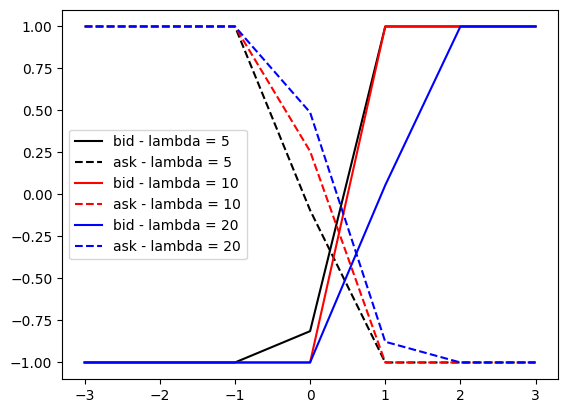

In [19]:
colors = ["k", "r", "b"]

for i, intensity in enumerate(intensities):
    plt.plot(inventories, bid_actions[intensity], label = f"bid - lambda = {intensity}", color = colors[i])
    plt.plot(inventories, ask_actions[intensity], label = f"ask - lambda = {intensity}", color = colors[i], linestyle = "--")
plt.legend()

In [20]:
timestamps = np.arange(0,1 + 0.01, 0.01)

In [21]:
bid_actions = {}
ask_actions = {}

# loop over intensities? (currently just using 10 below)
intensities = [5,10,15,20]

for intensity in intensities:

    bid_actions[intensity] = {}
    ask_actions[intensity] = {}
    
    for inventory in inventories:
        bid_actions[intensity][inventory] = []
        ask_actions[intensity][inventory] = []
        for timestamp in timestamps:
            state = np.array([[inventory, timestamp, intensity, intensity]])
            bid_action, ask_action = agent.get_action(state)[0]
            bid_actions[intensity][inventory].append(bid_action)
            ask_actions[intensity][inventory].append(ask_action)

In [22]:
#agent.get_action(state)

In [23]:
#model.predict(state, deterministic=True)

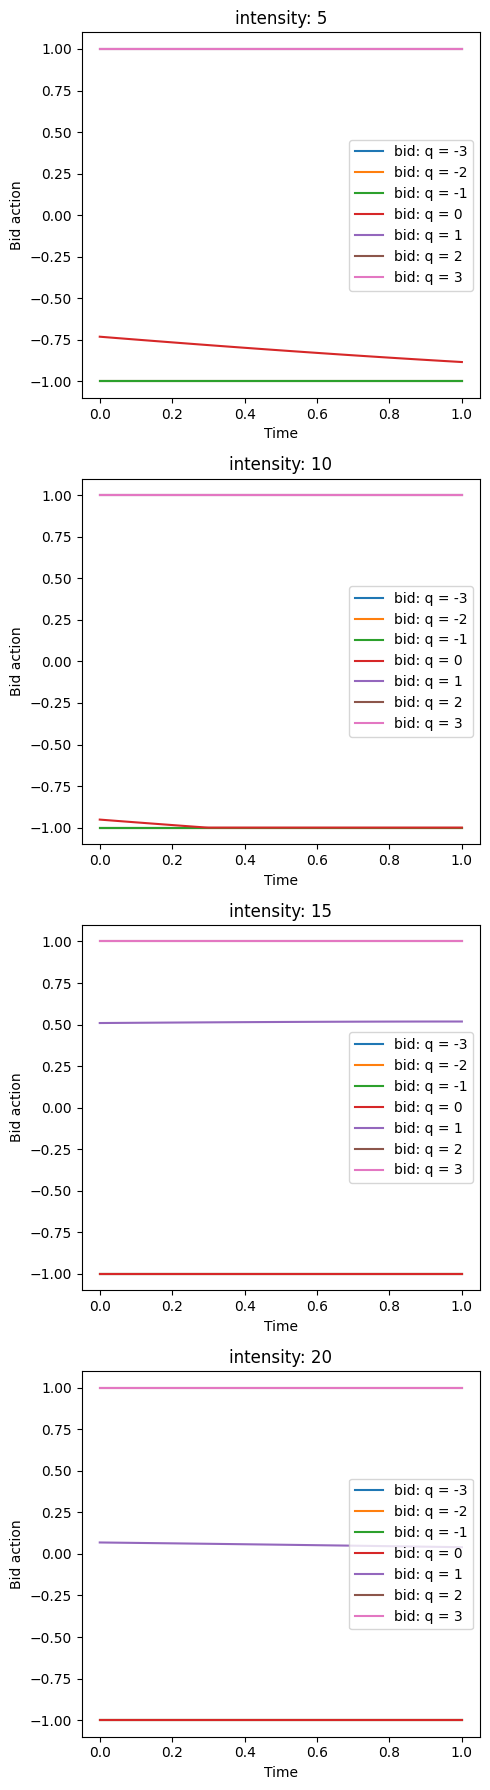

In [28]:
fig, axs = plt.subplots(len(intensities),1, figsize=(5,18))

for i,intensity in enumerate(intensities):
    
    ax = axs[i]

    for inventory in inventories:
        ax.plot(timestamps, bid_actions[intensity][inventory], label=f"bid: q = {inventory}")
        #print(bid_actions[intensity][inventory])
    ax.set_xlabel("Time")
    ax.set_ylabel("Bid action")  
    ax.set_title('intensity: %d' % intensity)
    ax.legend()
    
plt.tight_layout()

plt.show()

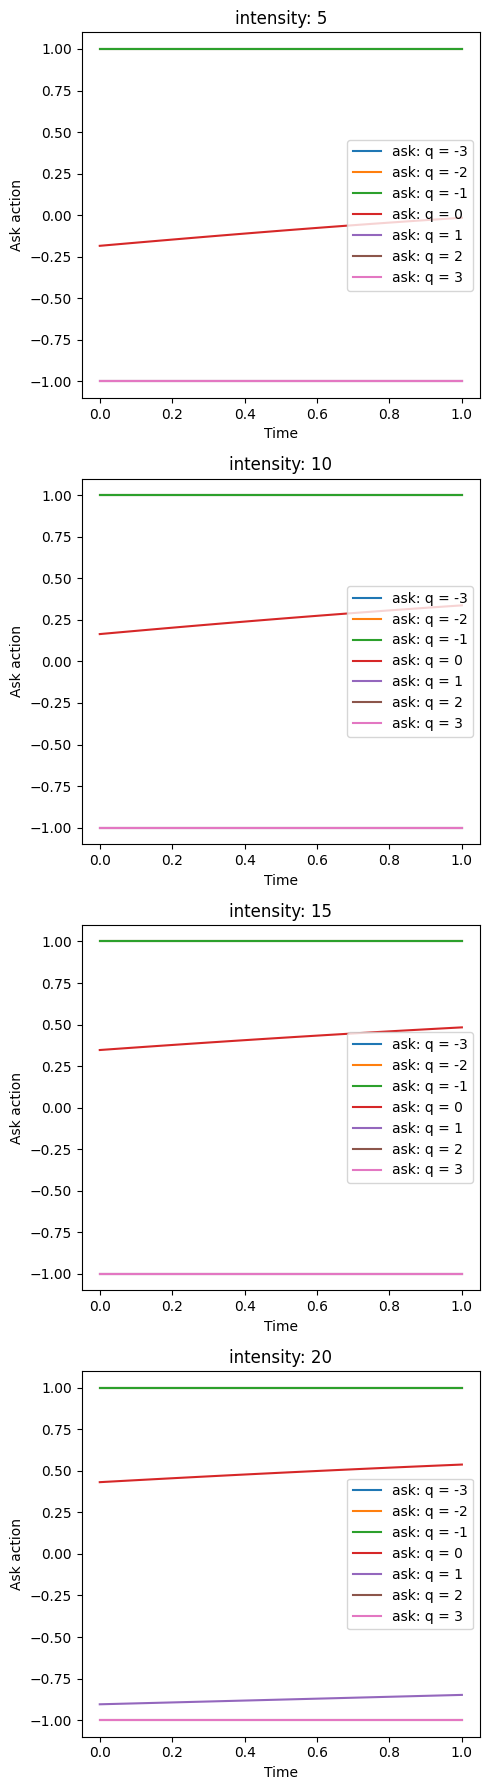

In [30]:
fig, axs = plt.subplots(len(intensities),1, figsize=(5,18))

for i,intensity in enumerate(intensities):
    
    ax = axs[i]

    for inventory in inventories:
        ax.plot(timestamps, ask_actions[intensity][inventory], label=f"ask: q = {inventory}")
        #print(bid_actions[intensity][inventory])
    ax.set_xlabel("Time")
    ax.set_ylabel("Ask action")  
    ax.set_title('intensity: %d' % intensity)
    ax.legend()
    
plt.tight_layout()

plt.show()

In [ ]:
model.save("trained_model")

In [ ]:
loaded = PPO.load("trained_model.zip")

In [ ]:
loaded

In [ ]:
ask_actions